## This Project: Style Transfer applied to a Chess Board

Purpose: Following this paper (https://arxiv.org/pdf/1508.06576.pdf) by Gatys et al, the purpose of the project was to create a new stylised chess board that could be used as a background for online games. The example used in this notebook was from a boards initial position, but it would not be difficult to change the 'content image' to one of a barebones chess board.

The idea behind style transfer is to take a pretrained image classification CNN model and use some of it's intermediate layers to redefine it's low-level and higher-level abstractions acording to some images we choose. As the model has been made to identify images, it converts the image into an internal representation of features it has found to describe the image most accurately. The features are what we will be using to 'match' the style onto our content images, recognising the image still as being that 'content' amongst it's most important features.

In [1]:
# importing libraries

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from PIL import Image
import re

### Importing both the 'style' and 'content' photos

In [2]:
def load_img(path):
    img = cv2.imread(path)
    img = np.float32(img)
    img = tf.expand_dims(img, 0) # for use in our keras models
    img = img / 255 # keeping all our color pixel values between 0 and 1
    return img

In [3]:
style_path = r"C:\Users\alecp\Desktop\PROJECT_CHESS\images\trunks_manet.jpg"
content_path = r"C:\Users\alecp\Desktop\Clean_Project_GHub\full_board.jpg"

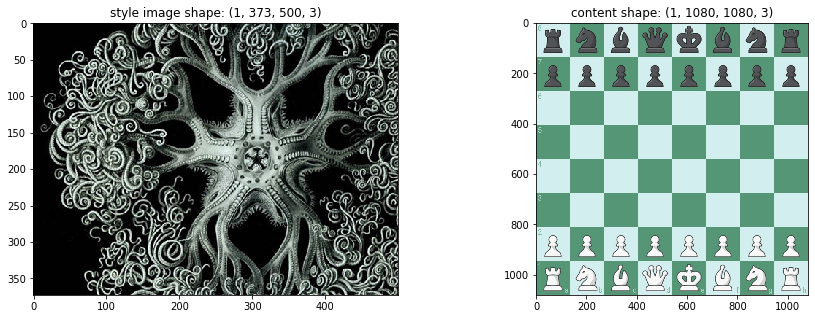

In [6]:
style_img = load_img(style_path)
fig, axs = plt.subplots(1, 2, figsize = (15,5))
axs[0].imshow(tf.squeeze(style_img))
axs[0].set_title(f'style image shape: {style_img.shape}')
content_img = load_img(content_path)
axs[1].imshow(tf.squeeze(content_img))
axs[1].set_title(f'content shape: {content_img.shape}')
plt.show()

### Loading Imagenets VGG CNN model

In [10]:
# looking at the layers within our downloaded vgg CNN model

vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
layers = []
for layer in vgg.layers:
    print(layer.name)
    layers.append(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
# designating all conv1 layers (the first after a max_pool/ change of dimensionality) to our style image
# designating the last conv2 layer to our content image leaving a stronger imprint as closest to the output

content_layers = [layers[-4]]
style_layers = [i for i in layers if 'conv1' in i]
print(f'content layers: {content_layers}')
print(f'style layers: {style_layers}')

content layers: ['block5_conv2']
style layers: ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


In [12]:
def vgg_layers(layer_names, model_name="Default"):
# building a VGG model based on a list of layers, referenced by their title
# input: layer names as defined within VGG structure, model name
# output: keras trainable and inferable CNN model

    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    # The output of each layer is retrieved in order to be plugged with input 
    # of next layer.
    # Each output is a tensor embedding all operations related to a specific 
    # layer.

    [print(name) for name in layer_names]
    outputs = [vgg.get_layer(name).output for name in layer_names]
    # model created from the first input layer and from the list of extracted layers specified from the VGG
    model = tf.keras.Model([vgg.input],  outputs, name=model_name)
    return model

In [13]:
style_extractor = vgg_layers(style_layers, "StyleExtractor")
style_extractor.summary()

block1_conv1
block2_conv1
block3_conv1
block4_conv1
block5_conv1
Model: "StyleExtractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____________________________________________________

In [15]:
content_extractor = vgg_layers(content_layers, "ContentExtractor")
content_extractor.summary()

block5_conv2
Model: "ContentExtractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, N

In [16]:
style_output = style_extractor(style_img*255)
content_output = content_extractor(content_img*255)

The style of an imaghe can be described by the means and correlation across the different feature maps (lower-level at the start of the network and higher-level towards the end). We then use a Gram Matrix (https://en.wikipedia.org/wiki/Gramian_matrix) that uses this information by taking the outer product of the feature vector against itself at each point and calculating the mean across all points. This can be calculated for a particular layer using:

**$G^l_{cd}$ = $\frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$**

which is implemented using the **tf.linalg.einsum** function.

In [26]:
def gram_matrix(input_tensor):
# The Gram Matrix is used to calculate the loss function to extract the style of the image.
# tf.linalg.einsum mesures a scalar product. The scalar product between 2 vectors is a measure of their similarity.
# The bilinear form is defined as being possitive, being a very practical property for a loss function.

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [27]:
class StyleContentModel(tf.keras.models.Model): # initialising our generic keras model
    def __init__(self, style_layers, content_layers):
        super().__init__(name="StyleContentModel")
        self.vgg =  vgg_layers(style_layers + content_layers, "StyleContentModel") # filling it with both our style and 
        # content models
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

In [23]:
test = StyleContentModel(style_layers, content_layers)
print("\nthis is a test....\nwe have {} style layers and {} content layers  ".format(test.num_style_layers, len(test.content_layers)))

block1_conv1
block2_conv1
block3_conv1
block4_conv1
block5_conv1
block5_conv2

this is a test....
we have 5 style layers and 1 content layers


In [28]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()

        self.vgg =  vgg_layers(style_layers + content_layers)

        self.style_layers = style_layers
        self.content_layers = content_layers

        self.num_style_layers = len(style_layers)

        self.vgg.trainable = False

    def __call__(self, inputs):
        # expecting the input to be between 0 and 1
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

        # extracting the output of our model created by our vgg_layers, where the image has been 
        # pre-treated with the tf.keras.applications.vgg19.preprocess_input method
        outputs = self.vgg(preprocessed_input)

        # splitting our layer outputs into style and content
        style_outputs = outputs[:self.num_style_layers] 
        content_outputs = outputs[self.num_style_layers:]

        # Claculating our Gram Matrix of each style layer, the otuput being a list of Gram Matrices
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        # dictionary structured as : {content_layer_name : output of that content layer}
        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        # dictionary structured as : {style_layer_name : Gram Matrix for that style layer}
        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
    
        return {'content':content_dict, 'style':style_dict}

In [25]:
extractor = StyleContentModel(style_layers, content_layers)
inputs = content_img*255.0
preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
print(preprocessed_input.shape)
print(len(extractor.vgg(preprocessed_input)))
extractor.vgg(preprocessed_input)[0].shape

block1_conv1
block2_conv1
block3_conv1
block4_conv1
block5_conv1
block5_conv2
(1, 1080, 1080, 3)
6


TensorShape([1, 1080, 1080, 64])

In [29]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_img))

block1_conv1
block2_conv1
block3_conv1
block4_conv1
block5_conv1
block5_conv2


In [30]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [31]:
def style_content_loss(outputs, style_weight, content_weight):

    # our Gram matrix for each style layer
    style_outputs = outputs['style']

    # our outputs for our content layer
    content_outputs = outputs['content']
    
    # using MSE for our loss functions
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)
    # style_loss = style_loss * (style_weight / len(style_layers))

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

In [32]:
opt = tf.optimizers.Adam(learning_rate=0.02)

In [33]:
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

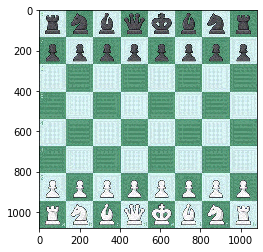

In [34]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, 1e-1, 1e-4)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image)) 
    # after being affected by the gradient, the pixel values can go outside of the 0, 1 range
    # therefore the clip_0_1 function is used to border our values between 0 and 1 again
  

image = tf.Variable(content_img)

# looking at our image after 3 iterations of our training step
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

EPOCH: 0 / 40
EPOCH: 1 / 40
EPOCH: 2 / 40
EPOCH: 3 / 40
EPOCH: 4 / 40
EPOCH: 5 / 40
EPOCH: 6 / 40
EPOCH: 7 / 40
EPOCH: 8 / 40
EPOCH: 9 / 40
EPOCH: 10 / 40
EPOCH: 11 / 40
EPOCH: 12 / 40
EPOCH: 13 / 40
EPOCH: 14 / 40
EPOCH: 15 / 40
EPOCH: 16 / 40
EPOCH: 17 / 40
EPOCH: 18 / 40
EPOCH: 19 / 40
EPOCH: 20 / 40
EPOCH: 21 / 40
EPOCH: 22 / 40
EPOCH: 23 / 40
EPOCH: 24 / 40
EPOCH: 25 / 40
EPOCH: 26 / 40
EPOCH: 27 / 40
EPOCH: 28 / 40
EPOCH: 29 / 40
EPOCH: 30 / 40
EPOCH: 31 / 40
EPOCH: 32 / 40
EPOCH: 33 / 40
EPOCH: 34 / 40
EPOCH: 35 / 40
EPOCH: 36 / 40
EPOCH: 37 / 40
EPOCH: 38 / 40
EPOCH: 39 / 40
Total time: 10636.6


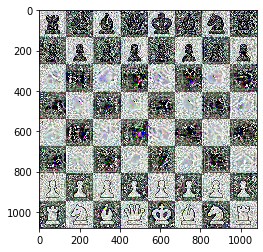

In [36]:
import time
start = time.time()

epochs = 40
steps_per_epoch = 20

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    
    print(f"EPOCH: {n} / {epochs}")
    Image.fromarray(np.asarray(image.read_value()[0] * 255).astype(np.uint8)).save('./tr_img_{:03d}.jpg'.format(n))

plt.imshow(image.read_value()[0])
end = time.time()
print("Total time: {:.1f}".format(end-start))

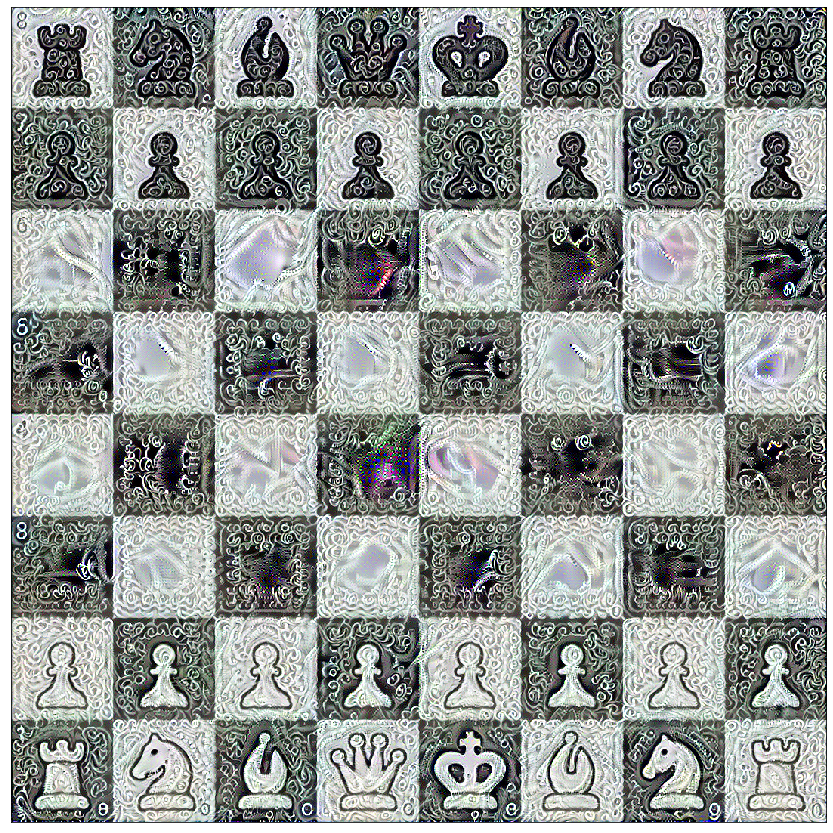

In [39]:
plt.figure(figsize = (15,15))
plt.imshow(image.read_value()[0])
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
# creating a gif of the saved images to see the progression of the transfer
img, *imgs = [Image.open(f) for f in [f'/content/images/tr_img_{str(num).zfill(4)}.jpg' for num in range(1,100)]]
img.save(fp=f"./style_board.gif", format='GIF', append_images=imgs,
          save_all=True, duration=100, loop=0)

In [40]:
# downloading images if code run on collab
!zip -r /content/file.zip /content/images
from google.colab import files
files.download("/content/file.zip")

In [ ]:
# to upscale the size of the image (https://towardsdatascience.com/deep-learning-based-super-resolution-with-opencv-4fd736678066)
# I used a pretrained CNN model, 'EDSR_x4' upscaling the image byy a factor of 4, the model can be found within the webpage
import cv2
from cv2 import dnn_superres

# Create an SR object
sr = dnn_superres.DnnSuperResImpl_create()

imaged = np.float32(image.read_value()[0]) * 255
path = "/content/EDSR_x4.pb"
sr.readModel(path)

# Set the desired model and scale to get correct pre- and post-processing
sr.setModel("edsr", 4)
result = sr.upsample(imaged)

cv2.imwrite("./upscaled_tr.png", result)

True